In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Loading the CSV
file_path = 'CarSharing_Preprocessed.csv'  
df = pd.read_csv(file_path)

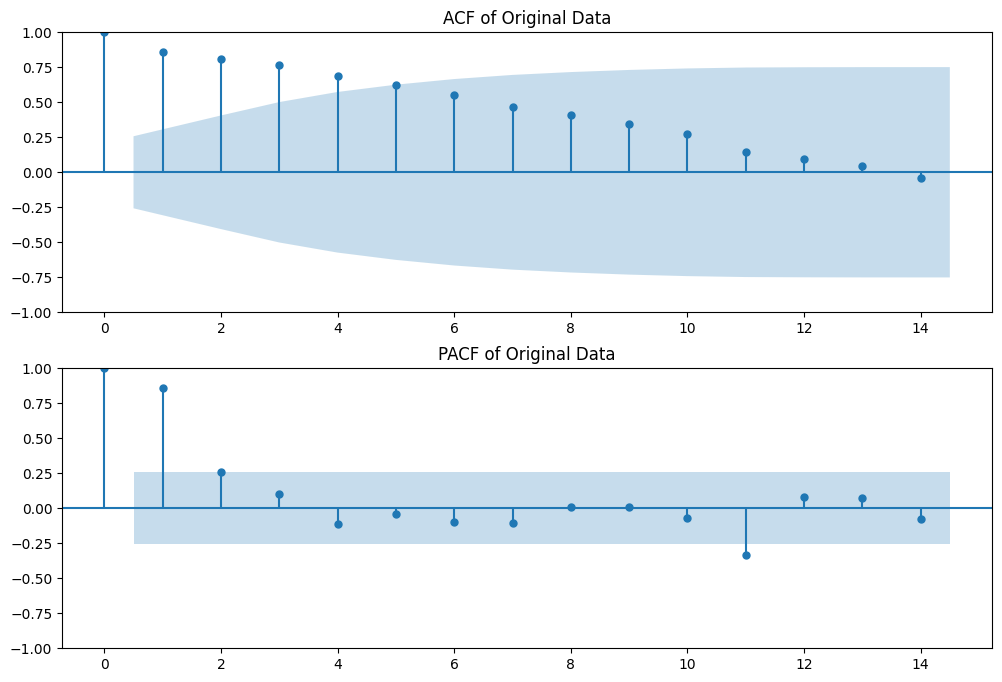

ADF Statistic: -1.952872017032954
p-value: 0.3076114019162719
The series is not stationary. p-value is greater than 0.05.


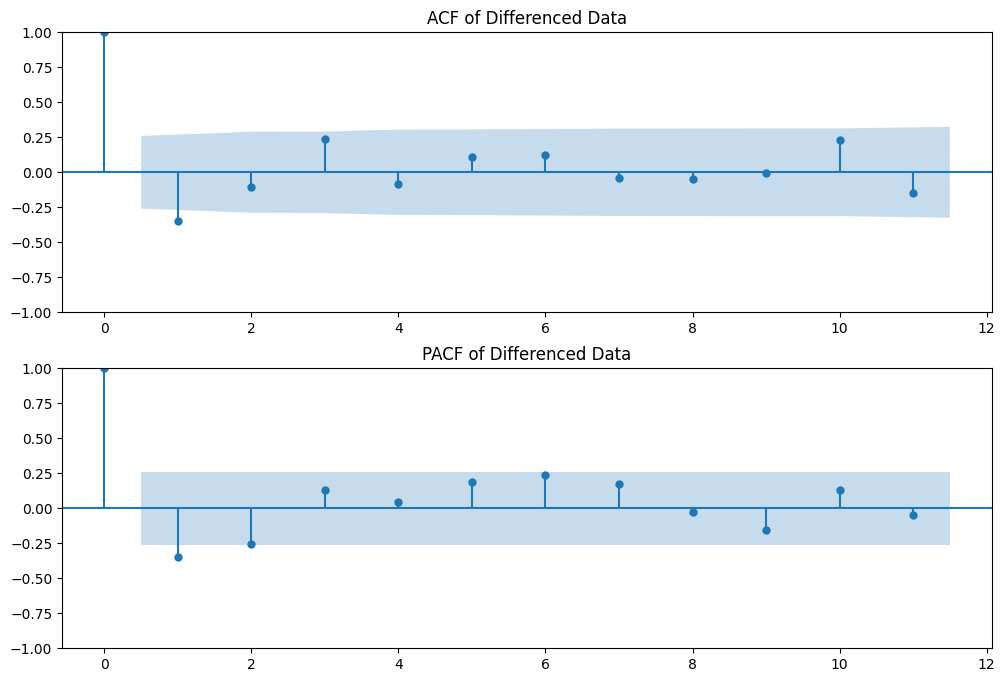


ADF Statistic (differenced data): -4.615826552832493
p-value (differenced data): 0.0001207659998248131
The series is stationary. p-value is less than 0.05.


In [6]:
# Converting "timestamp" column to datemine and setting it as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Weekly average of 'demand' and interpolating missing values
weekly_demand_pre = df['demand'].resample('W').mean()
weekly_demand = weekly_demand_pre.interpolate()

# Splitting data into 70% training and 30% testing (as required)
split_point = int(len(weekly_demand) * 0.7)
train, test = weekly_demand.iloc[:split_point], weekly_demand.iloc[split_point:]

# Determining and plotting the max lags for ACF/PACF plots
n_obs = train.shape[0]
max_lags = min(14, n_obs - 1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train.dropna(), lags=max_lags, ax=ax1)
ax1.set_title('ACF of Original Data')
plot_pacf(train.dropna(), lags=max_lags, ax=ax2)
ax2.set_title('PACF of Original Data')
plt.show()

# ADF test to check stationarity
adf_result = adfuller(train.dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] <= 0.05:
    print("The series is stationary. p-value is less than 0.05.")
else:
    print("The series is not stationary. p-value is greater than 0.05.")

# Differencing the data to achieve stationarity
train_diff = train.diff().dropna()


# Plot ACF and PACF for differenced data
n_obs_diff = train_diff.shape[0]
max_lags_diff = min(11, n_obs_diff - 1)
fig, (ax1_diff, ax2_diff) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_diff, lags=max_lags_diff, ax=ax1_diff)
ax1_diff.set_title('ACF of Differenced Data') 
plot_pacf(train_diff, lags=max_lags_diff, ax=ax2_diff)
ax2_diff.set_title('PACF of Differenced Data')
plt.show()

# ADF test on differenced data
adf_result_diff = adfuller(train_diff)
print(f'\nADF Statistic (differenced data): {adf_result_diff[0]}')
print(f'p-value (differenced data): {adf_result_diff[1]}')
if adf_result_diff[1] <= 0.05:
    print("The series is stationary. p-value is less than 0.05.")
else:
    print("The series is not stationary. p-value is greater than 0.05.")


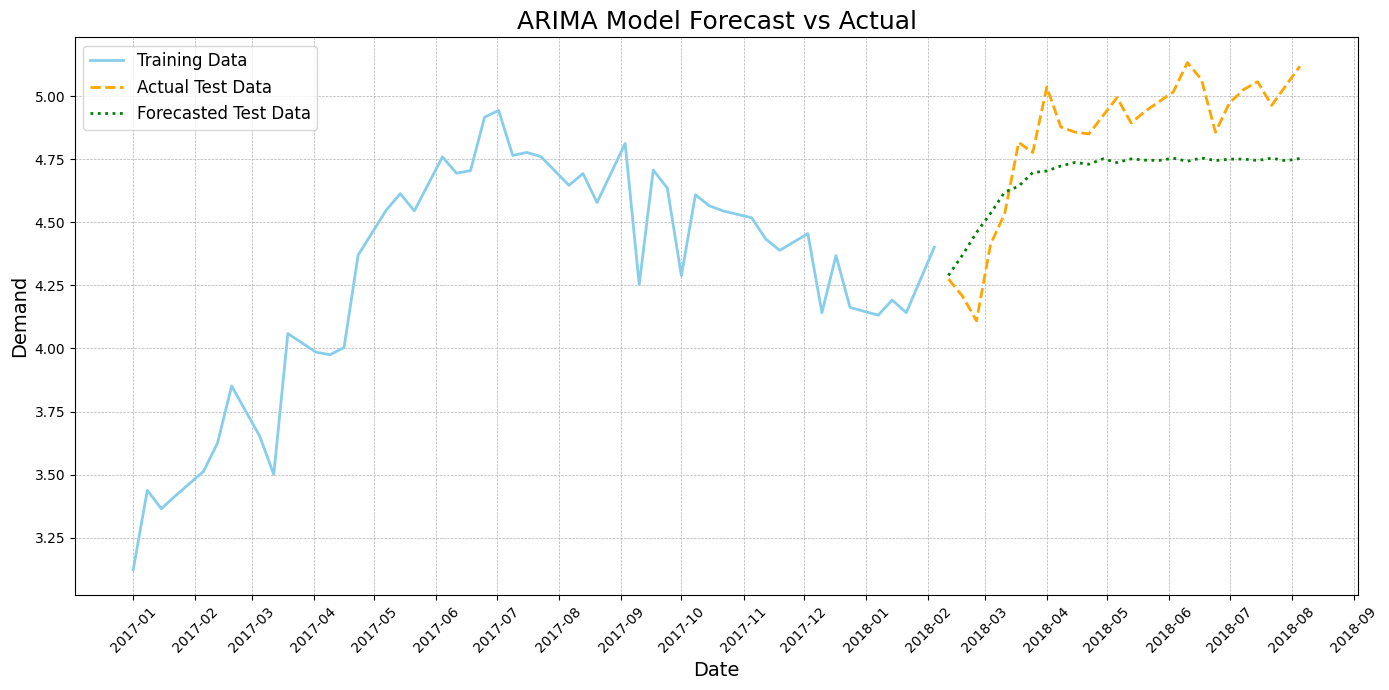

In [7]:
# Fitting the ARIMA model and Forecasting
model = ARIMA(train, order=(4, 1, 4))
model_fit = model.fit()
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)


# Plot training, actual test, and forecasted data
plt.figure(figsize=(14, 7))  
plt.plot(train.index, train, color='skyblue', linewidth=2, label='Training Data', linestyle='-')
plt.plot(test.index, test, color='orange', linewidth=2, label='Actual Test Data', linestyle='--')
plt.plot(test.index, forecast, color='green', linewidth=2, label='Forecasted Test Data', linestyle=':')
plt.title('ARIMA Model Forecast vs Actual', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [8]:
# MAE, MSE, RMSE
mae = np.mean(np.abs(test - forecast))
mse = np.mean((test - forecast)**2)
rmse = np.sqrt(mse)

print("\nARIMA: Mean Absolute Error (MAE):", mae)
print("ARIMA: Mean Squared Error (MSE):", mse)
print("ARIMA: Root Mean Squared Error (RMSE):", rmse)
print("\n")


ARIMA: Mean Absolute Error (MAE): 0.2104904971561388
ARIMA: Mean Squared Error (MSE): 0.05380976950007879
ARIMA: Root Mean Squared Error (RMSE): 0.23196932879171503


